<div style='width:500px; height:220px; border-bottom:10px black solid;border-left: 10px green solid;padding: 10px 10px 10px 10px;'>
    <h1> ---Portofolio Optimization Plot---</h1>
    <h3> Author: Jakob Lindstrøm </h3>
    <h3> Date: 03.05.2023 </h3>
</div>

<div style='width:600px; height:800px; padding: 10px 10px 10px 10px;border-bottom:10px black solid;
            border-left: 10px green solid'>
    <div>
        <h4>Keywords:</h4>
        <p> Stocks, portfolio, optimization, finance </p>
        <h4> Data sources:  </h4>
        <p> yfinance: https://pypi.org/project/yfinance/ </p>
        <p> DNB markets: https://www.dnb.no/bedrift/markets/analyser/arkiv/anbefalteaksjer.html </p>
        <h4> Intention: </h4>
        <p> This programe has the goal of finding the optimal weigths for a given amount of stocks in a portofolio. The programe uses live-data from the python library yfinance to collect stock data. Furthermore the stocks will be modelled in regard to different portfolio weigths. There will be three optimzed portofolios for: minimum variance, highest Sortino ratio and highest Sharpe ratio. You are completely free to choose which stocks to include in the portfolio, I use the weekly recommended stocks from DNB markets. </p>
        <br>
        <p>Furthermore the weights  of one portfolio will be used to create a machine learning model to predict and forecast upcoming values. </p>
        <br>
        <h4> Disclaimer: </h4>
        <p> The author do not take any responsibility for potential consequences thats been a result of using the code below. </p>
    </div>
</div>

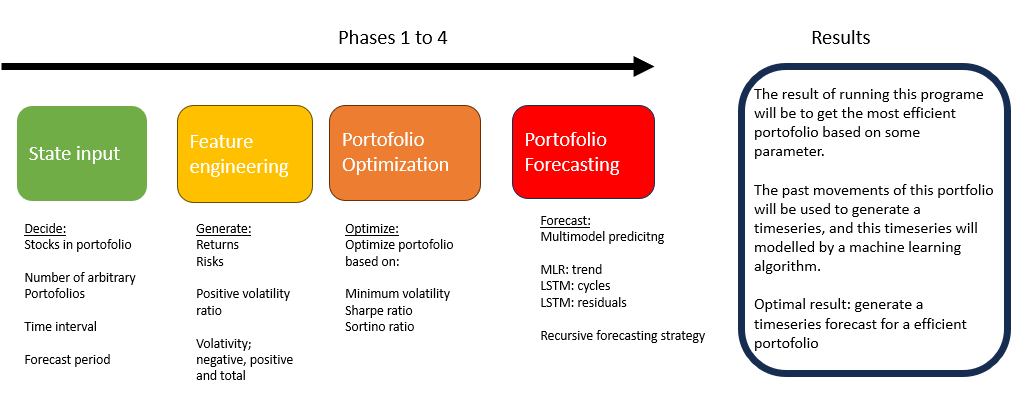

<h1> Table of content </h1>
<ol>
<li>Importing libraries</li>
<li>State input and retrieval</li>
<li>Feature engineering</li>
<li>Random portofolios</li>
<li>Optimization on Sharpe and Sortino</li>
<li>Plot over different portofolios</li>
<li>Machine Learning on time series</li>
<ol>
<li>Trend</li>
<li>Cycles</li>
<li>Residuals</li>

</ol>
<li>Forecasting</li>
<li>Summary</li>

</ol>

<em> Possible improvements:
<ol>
<li> Use logaritmic stock returns</li>
<li> Generate a random walk, with a modified distributions in accordance to each stock distributions</li>
<li> Investigate different ML-models for modelling cycles and residuals</li>
<li> Make the time series component analysis more automized.</li>
<li> Come up with new ideas, for example include a modified random walk adjusted to a Cholensky matrix. </li>
<li> ...</li>

</ol></em>

<h1> 1. Importing libraries

In [470]:
#Importing libraries


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random as rd
import math 
from math import sqrt

import yfinance as yf   
from datetime import datetime

import scipy.stats as st
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_pacf

from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize

from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_percentage_error as MAPE


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras import layers, callbacks


import warnings
warnings.filterwarnings("ignore")

<h1> 2. State input and retrieve it </h1>
<p> Below one shall state the input for the programme. Which stocks to include, for how long a time, how many arbitrary portofolios and the length of the forecast period. 

In [471]:
#INPUT FIELD:   
stocks = ['AKRBP.OL','ATEA.OL','EQNR.OL','EPR.OL','LSG.OL','MOWI.OL','SRBNK.OL','SUBC.OL']
#format: year-month-day
startPor = '2018-01-01'
hold_portofolio_days = 21
portofolio_Distributions = 1000
endDate = datetime.now().strftime('%Y-%m-%d')
#format: year-month-day
# endDate = '2023-01-29'

# Monte Carlo simulation
forecast_period = 40

In [566]:
#Retrieve financial data from yahoo finace


def dataRetriever():
    df = []
    for i in range(0,len(stocks),1):
        yahoo = yf.download(stocks[i], start=startPor, end=endDate)
        data = [0]
        for j in range(0, len(yahoo['Adj Close'])-1,1):
            selecive_data = ((yahoo['Adj Close'][j+1]/yahoo['Adj Close'][j])-1)
            data.append(selecive_data)
        adj_close = yahoo['Adj Close']
        relevant  = [stocks[i], data, adj_close]
        df.append(relevant)
    return df
mystocks = dataRetriever()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


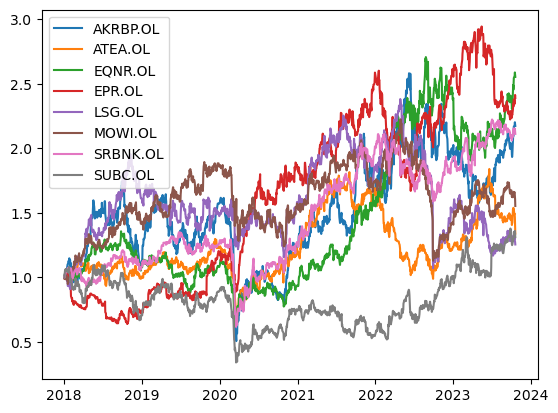

In [ ]:
#Plot the past movement for the different stocks


fig, ax = plt.subplots()
for i in range(len(mystocks)):
    ax.plot(mystocks[i][2]/mystocks[i][2][0], label=stocks[i])
plt.legend()
plt.show()

<h1> 3. Feature engineering (ratios, risks and returns) </h1>
<p> This section of the programme will define vital information of the stocks. Covariance matrix, risks and returns.

In [ ]:
#Create a ratio for the number of positive moves each stock has
#Add this ratio to the list of stocks


def pos_ratio():
    pos_ratio_list = []
    for i in range(0,len(mystocks),1):
        pos_ratio = np.where(np.array(mystocks[i][1])>0,1,0).sum()/len(mystocks[i][1])
        pos_ratio_list.append(pos_ratio)
    return pos_ratio_list

pos_ratio_stock = pos_ratio()

In [ ]:
#Create mean returns for each stock


def means():
    means = []
    for i in range(0,len(mystocks),1):
        means.append(pd.Series(mystocks[i][1]).mean())
    return np.array(means)
mean = means()

def stds():
    means = []
    for i in range(0,len(mystocks),1):
        means.append(pd.Series(mystocks[i][1]).std())
    return np.array(means)
std = stds()

In [ ]:
#Create different portofolio risk matrices based 
#on total risk, downside risk and upside risk


total_cov_matrix = pd.DataFrame()
negative_cov_matrix =  pd.DataFrame()
positive_cov_matrix = pd.DataFrame()

for i in range(0, len(mystocks),1):
    total_cov_matrix[mystocks[i][0]] = mystocks[i][1]

    stock = pd.Series(mystocks[i][1])

    neg = stock.loc[stock < 0]
    negative_cov_matrix[mystocks[i][0]] = neg

    pos = stock.loc[stock > 0]
    positive_cov_matrix[mystocks[i][0]] = pos

negative_cov_matrix =  negative_cov_matrix.cov()
total_cov_matrix = total_cov_matrix.cov()
positive_cov_matrix = positive_cov_matrix.cov()

<h1> Random portofolios </h1>
<p> Now a various of portfolios will be generate and information about them will be added into a dataframe.

In [ ]:
#Generate random weigths for all stocks in each portofolio n times


def portofolio_generator():
    portofolios = []
    for i in range(0,portofolio_Distributions,1):
        single = np.random.dirichlet(np.ones(len(stocks)),size=1)
        portofolios.append(single)
    return portofolios
portofolios = portofolio_generator()

In [ ]:
#Create returns for each portofolio


def portofolioReturns(ps):
    returns = []
    for i in range(0, len(ps),1):
        returns.append(sum(mean@ps[i].T))
    return returns
returns = portofolioReturns(portofolios)

In [ ]:
# Generate standard deviation for portofolios
# ps = portofolios, cov = covariance matrix

def portofolio_std(ps, cov):
    #ps is short for portofolios
    pstd = [(ps[i] @ cov @ ps[i].T)**.5 for i in range(len(ps))]
    portofolio_std = pd.Series([pstd[i][0][0] for i in range(len(ps))])

    return portofolio_std



#Calculate the different risktypes for each portofolio
neg_risk = portofolio_std(portofolios, negative_cov_matrix)
tot_risk = portofolio_std(portofolios, total_cov_matrix)
pos_risk = portofolio_std(portofolios, positive_cov_matrix)

In [ ]:
#Create a function to predict the ratio of 
#positive moves a portofolio will have


def por_pos_ratio(ps):
    por_pos_ratio = [ps[i][0]@(np.array(pos_ratio_stock)-0.5) 
                     for i in range(len(ps))]

    return por_pos_ratio
por_movement_ratio_dir = por_pos_ratio(portofolios)


In [ ]:
#Create a dataframe containing all portofolios
#with a predicted return over 0%


def dfOutput():
    
    df = pd.DataFrame()
    colnames =  ['Weigths', 'Return', 'Total_risk','Negative_risk', 'Positive_risk','Pos_risk_ratio']
    colvalues = [portofolios, returns, tot_risk, neg_risk, pos_risk, por_movement_ratio_dir]
    
    for i in range(0,len(colnames),1):
        df[colnames[i]] = colvalues[i]
    df['Sharpe_Ratio'] = df['Return']/(df['Total_risk'])
    df['Sharpe_Ratio'] = colvalues[1]/(colvalues[2])
    df['Sortino_Ratio'] =df['Return']/(df['Negative_risk']+1)
    df = df.loc[df['Return'] >= 0].reset_index()
    del df['index']

    return df
df = dfOutput()

<h1> Optimzation on Sharpe and Sortino

Now that the feature engineering part is done, one can optimize a portofolio. I have choosen to optimze three portofolios in regard to minimum variance, highest Sortino ratio and highest Sharpe ratio.  <br>
<p> Inspiration: https://www.kaggle.com/code/trangthvu/efficient-frontier-optimization </p>

In [ ]:
c1 = Bounds(0,1)

#Creating arbitrary values for weigths
c2 = LinearConstraint(np.ones((len(stocks),), dtype=int),1,1)

#Creating arbitrary values for the weigths
weigths = np.ones(len(stocks))
#And making them add up to 100%.
decVar = weigths/np.sum(weigths)


opt_port = []
opt_spec = ['Minimum Variance', 'Highest Sortino', 'Highest Sharpe']
special_params = [total_cov_matrix,negative_cov_matrix,total_cov_matrix]
for i in range(0,3,1):
    if  i ==0:  
        Z = lambda w: np.sqrt(w@special_params[i]@w.T)
    else:
        Z = lambda w: np.sqrt(w@special_params[i]@w.T)/(mean@w)

    res = minimize(Z, decVar, method='trust-constr', constraints = c2, bounds = c1)
    w = res.x
    ret = sum(w*mean)
    risk = (w@total_cov_matrix@w.T)**.5
    opt_port.append([w, ret, risk, opt_spec[i]])


<h1> 6 Plot over different portofolios

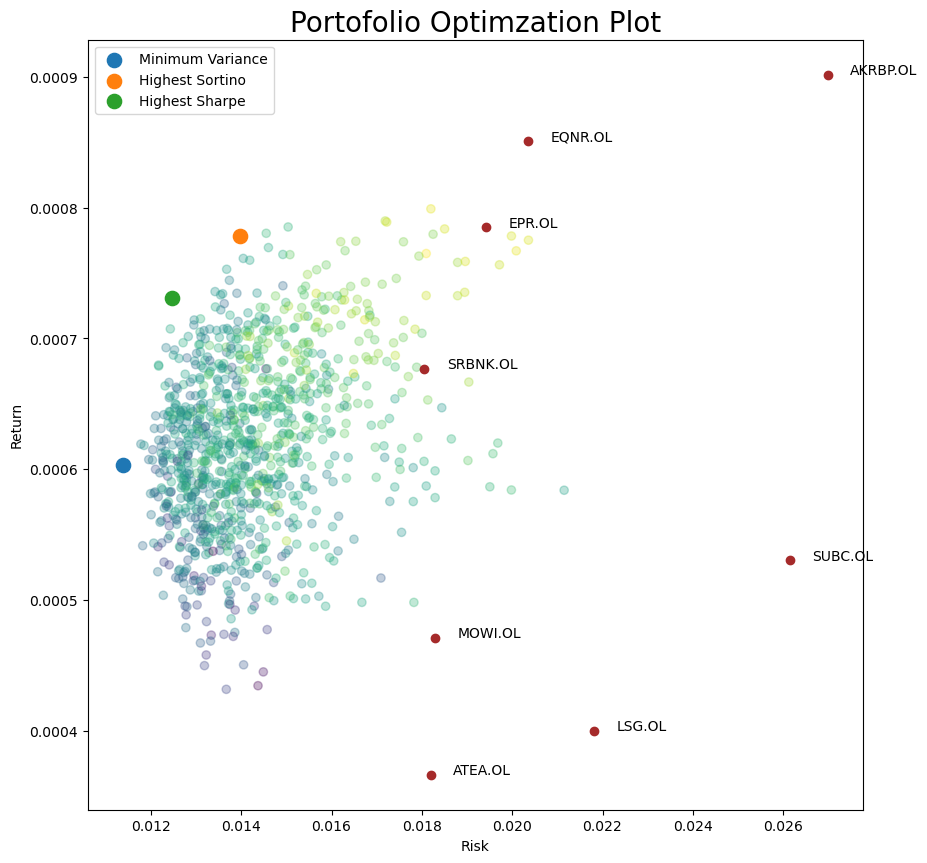

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(y=returns, x=tot_risk, c=df['Pos_risk_ratio'],
           marker='o', alpha=.3)

for i in range(3):
    ax.scatter(x=opt_port[i][2],y=opt_port[i][1], label=opt_port[i][3], s=105)

ax.scatter(y=mean, x= std,color='brown')
for i in range(len(stocks)):
    plt.annotate(stocks[i], (std[i]+0.0005,mean[i]))
plt.xlabel('Risk')
plt.ylabel('Return')
plt.legend()
plt.title('Portofolio Optimzation Plot', fontsize=20)
plt.show()
plt.savefig('opt_ex.png')

Looking at the plot above one can see how the risk and returns varies from different weigths in the portofolio. I will personally choose the portofolio with the highest Sharpe ratio, and try to model it.

In [ ]:
# Choosing my portfolio, I choose the highest sharpe ratio
best_por = opt_port[2][0]

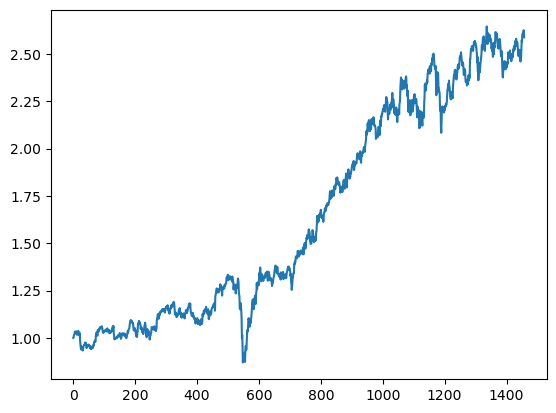

In [ ]:
time_cum = []
for i in range(0, len(mystocks[0][1])):
    day_cum = []
    day_sel = 0

    for j in range(len(best_por)):
        day_sel += best_por[j]*mystocks[j][1][i]
        if j == (len(best_por)-1):
            
            day_cum.append(day_sel+1)
    time_cum.append(day_cum[0])

portofolio_actual_movement = pd.Series(np.cumprod(time_cum))
portofolio_actual_movement.plot()
plt.show()

<h1>7 Machine Learning on time series </h1>
<p> Now I will try to create a ML model that can forecast my choosen portofolio. I will use all the different time series components, except for seasonality. In other words; I will try to capture the trend, cycles and seasonality of the time series. I will use a recursive strategy for forecasting. <br>
<p> Inspiration: https://www.kaggle.com/learn/time-series </p>
<br>
<p> Inspiration: https://github.com/Henrkkn/The-Forecasting-World/blob/main/LSTM.ipynb </p>
<br>
<p>Inspiration: https://www.kaggle.com/learn/intro-to-deep-learning </p>

<h2> 7.1 Trend

In [ ]:
#Creating X and y ffeature for capturing the trend


y = portofolio_actual_movement.copy()
dp = DeterministicProcess(index=y.index,
                          constant=True,
                          order=2,
                          drop=True)
X = dp.in_sample()


In [ ]:
# Splitting the data into different sets
def tts(X,y):
    idx_train, idx_test = train_test_split(y.index,
                                        test_size=60,
                                        random_state=42,
                                        shuffle=False)
    X_train, y_train = X.loc[idx_train,:], y.loc[idx_train]
    X_test, y_test = X.loc[idx_test,:], y.loc[idx_test]
    return [X_train,y_train, X_test,y_test]

first_split = tts(X, portofolio_actual_movement)
X_train, y_train = first_split[0],first_split[1]
X_test, y_test = first_split[2], first_split[3]

In [ ]:
fit_idx = np.linspace(0, len(X_train), len(X_train))
pred_idx = np.linspace(len(y_train)+1, len(y_train)+len(X_test),len(X_test))

In [ ]:
# Fitting a linear regression model to capture trend
model1 = LinearRegression()
model1.fit(X_train, y_train)

# Predict the train and test set
y_fit_trend = pd.Series(model1.predict(X_train),
                  index=y_train.index)

y_pred_trend = pd.Series(model1.predict(X_test), 
                      index=y_test.index)

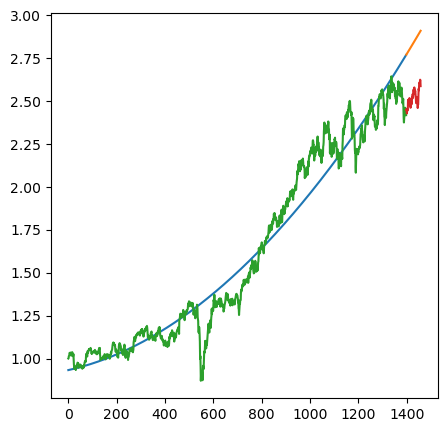

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(y_fit_trend)
ax.plot(y_pred_trend)
ax.plot(y_train)
ax.plot(y_test)

<h2> 7.2 Cycles </h2>
<p> This cycle section hasnt been automized yet. Here its important to choosen the number of lagged variables one want. This input shall go in to the "generate_lags" function.

In [ ]:
def normalize(arr):
    answer = (arr-arr.mean())/arr.std()
    return answer

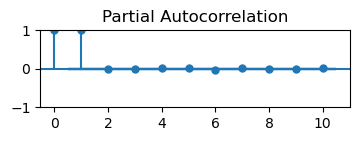

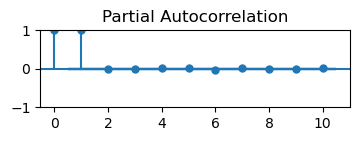

In [ ]:
fig, ax = plt.subplots(figsize=(4,1))
plot_pacf(y, lags=10, ax=ax)

In [497]:
def generate_lags(data, n_lags):
    df = pd.DataFrame()
    for i in range(1,n_lags+1,1):
        df['lag'+str(i)] = data.shift(i, fill_value=1)
    return df



X_train_cyc = generate_lags(y_train,1)
X_test_cyc = generate_lags(y_test,1)

y_train_cycle = y_train - y_fit_trend
y_test_cycle = y_test - y_pred_trend

X_train_cyc_1 = np.reshape(np.array(X_train_cyc), (X_train_cyc.shape[0],X_train_cyc.shape[1],1))
X_test_cyc_1 = np.reshape(np.array(X_test_cyc), (X_test_cyc.shape[0],X_test_cyc.shape[1],1))


<AxesSubplot:>

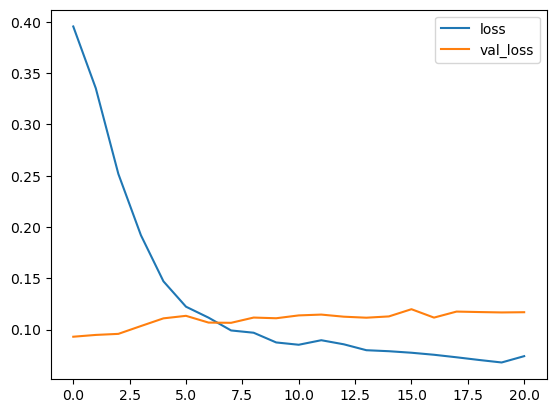

In [511]:
lstm1 = Sequential()

lstm1.add(BatchNormalization(input_shape=(X_train_cyc_1.shape[1],X_train_cyc_1.shape[2])))


lstm1.add(LSTM(units=40, activation='relu', return_sequences=True))
lstm1.add(BatchNormalization())
lstm1.add(Dropout(0.3))

lstm1.add(LSTM(units=30, activation='tanh', return_sequences=True))
lstm1.add(BatchNormalization())
# lstm1.add(Dropout(0.3))

# lstm1.add(LSTM(units=20, activation='relu', return_sequences=True))


# lstm1.add(LSTM(units=32, activation='selu', return_sequences=True))
# lstm1.add(BatchNormalization())
# lstm1.add(Dropout(0.3))

lstm1.add(Dense(units=1))


# Make the compiler
lstm1.compile(
    optimizer='adam',
    loss='mean_absolute_error'
)


# Make a early stopping
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

lstm1.fit(
    X_train_cyc_1, y_train_cycle,
    validation_split= 0.2,
    batch_size=256,
    epochs=60,
    callbacks=early_stopping,
    verbose=0
)


history1 = lstm1.fit(
    X_train_cyc_1, y_train_cycle,
    validation_split= 0.2,
    batch_size=200,
    epochs=100,
    callbacks=early_stopping,
    verbose=0
)

history_df1 = pd.DataFrame(history1.history)
history_df1.loc[:,['loss','val_loss']].plot()

2/2 [==============================] - 0s 3ms/step


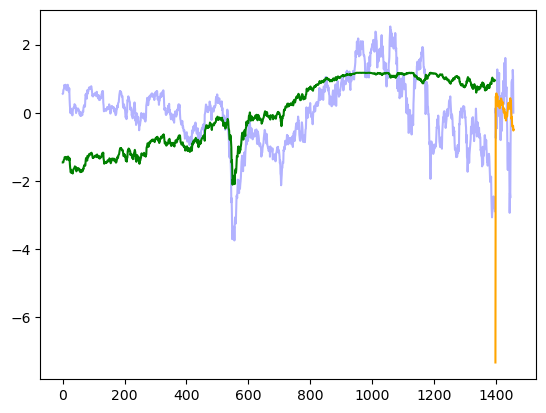

In [529]:
y_fit_cyc = lstm1.predict(X_train_cyc_1)
y_pred_cyc = lstm1.predict(X_test_cyc_1)

y_fit_cyc_1 = pd.Series([y_fit_cyc[i][0][0] for i in range(len(y_fit_cyc))])
y_pred_cyc_1 = pd.Series([y_pred_cyc[i][0][0] for i in range(len(y_pred_cyc))])

fig, ax = plt.subplots()
ax.plot(normalize(y_train_cycle), color='b', alpha=.3)
ax.plot(normalize(y_test_cycle), color='b', alpha=.3 )
ax.plot(normalize(y_fit_cyc_1), color='green')
ax.plot(pred_idx, normalize(y_pred_cyc_1), color='orange')

<h2> 7.3 Residuals </h2>


In [548]:
# Define new target variable
y_train_resid = y_train - y_fit_trend - y_fit_cyc_1
y_test_resid = y_train - y_pred_trend -  y_pred_cyc_1


# Define new explanatory variables
X_train_resid = pd.concat([X_train, X_train_cyc],axis=1)
X_test_resid = pd.concat([X_test, X_test_cyc], axis=1)


# Reshape the new explanatory variables
X_train_resid_1 = np.reshape(np.array(X_train_resid), (X_train_resid.shape[0],X_train_resid.shape[1],1))
X_test_resid_1 = np.reshape(np.array(X_test_resid), (X_test_resid.shape[0],X_test_resid.shape[1],1))

<AxesSubplot:>

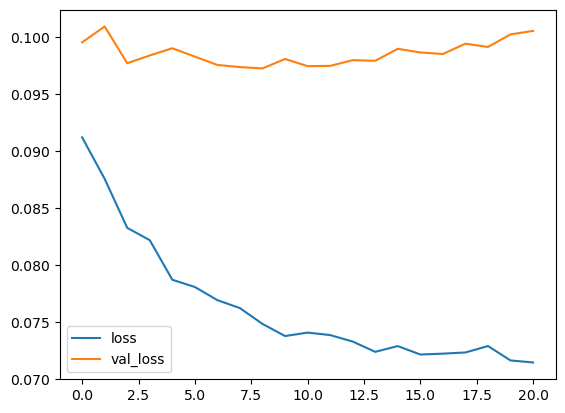

In [558]:
lstm2 = Sequential()

lstm2.add(BatchNormalization(input_shape=(X_train_resid_1.shape[1],X_train_resid_1.shape[2])))

lstm2.add(LSTM(units=20, activation='tanh', return_sequences=True))
# lstm2.add(BatchNormalization())
lstm2.add(Dropout(0.3))

# lstm2.add(LSTM(units=30, activation='selu', return_sequences=True))
lstm2.add(BatchNormalization())
# lstm2.add(Dropout(0.3))

lstm2.add(LSTM(units=30, activation='relu', return_sequences=True))
# lstm2.add(BatchNormalization())
# lstm2.add(Dropout(0.3))

lstm2.add(Dense(units=1))


# Make the compiler
lstm2.compile(
    optimizer='adam',
    loss='mae'
)


# Make a early stopping
early_stopping = EarlyStopping(
    min_delta=0.005, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

lstm2.fit(
    X_train_resid_1, y_train_resid,
    validation_split= 0.2,
    batch_size=200,
    epochs=100,
    callbacks=early_stopping,
    verbose=0
)


history2 = lstm2.fit(
    X_train_resid_1, y_train_resid,
    validation_split= 0.2,
    batch_size=200,
    epochs=100,
    callbacks=early_stopping,
    verbose=0
)

history_df2 = pd.DataFrame(history2.history)
history_df2.loc[:,['loss','val_loss']].plot()

2/2 [==============================] - 0s 2ms/step


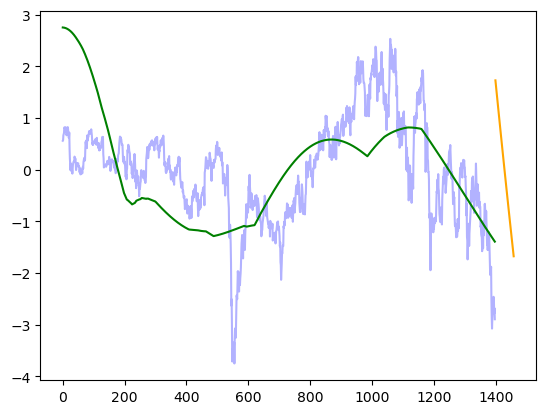

In [559]:
y_fit_resid = lstm2.predict(X_train_resid_1)
y_pred_resid = lstm2.predict(X_test_resid_1)

y_fit_resid_1 =np.array([sum(y_fit_resid[i])[0] for i in range(len(y_fit_resid))])
y_pred_resid_1 = np.array([sum(y_pred_resid[i])[0] for i in range(len(y_pred_resid))])


fig, ax = plt.subplots()
ax.plot(normalize(y_train_resid), color='b', alpha=.3)
ax.plot(normalize(y_fit_resid_1), color='green')
ax.plot(pred_idx, normalize(y_pred_resid_1), color='orange')

<h1> 8 Forecasting </h1>
<p> Now I will try to forecast the model based on my previous findings. 

In [560]:
final_fit  = y_fit_trend + y_fit_cyc_1 + y_fit_resid_1
final_pred = y_pred_trend.reset_index()[0] + y_pred_cyc_1 + y_pred_resid_1

final_fit_mae = round(MAPE(final_fit, y_train),2)
final_pred_mae = round(MAPE(final_pred, y_test),2)

In [561]:
# Multimodel function for forecasting values


def multi_model(pred):

    new_y1 = model1.predict(pred.loc[:,: 'trend_squared'])

    new_X2 = np.reshape(np.array(pred['lag1']),(1,1,1))
    new_y2 = lstm1.predict(new_X2)

    new_X3 =  np.reshape(np.array(pred),(1,4,1))
    new_y3 = lstm2.predict(new_X3)

    new_forecast = new_y1[0] + new_y2[0] + sum(new_y3[0])[0]

    return new_forecast

In [562]:
# Forecast function that uses a Recursive strategy

def recursive():
    forecast_features = pd.DataFrame(columns= ['const', 'trend', 'trend_squared', 'lag1'], index=[0])
    previous_row = X_test_resid.iloc[-1:].reset_index()
    forecasts = []

    for i in range(0,  40,1):
        if i == 0:
            previous_target = y_test[-1:].reset_index()[0][0]
        else:
            previous_target = forecasts[-1]

        new_row = [1, 
                previous_row['trend'][0]+i,
                (previous_row['trend'][0]+i)**2,
                previous_target]
        new_pred = pd.DataFrame({'const':new_row[0],
                                'trend':new_row[1],
                                'trend_squared':new_row[2],
                                'lag1':new_row[3]}, 
                                index=[i])
        
        forecasts.append(multi_model(new_pred)[0][0])


        forecast_features.loc[i] = new_row
    
    return [forecasts, forecast_features]


In [564]:
forecasts = recursive()[0]
for_idx = np.linspace(len(y)+1, len(y)+len(forecasts),forecast_period)

1/1 [==============================] - 0s 19ms/step


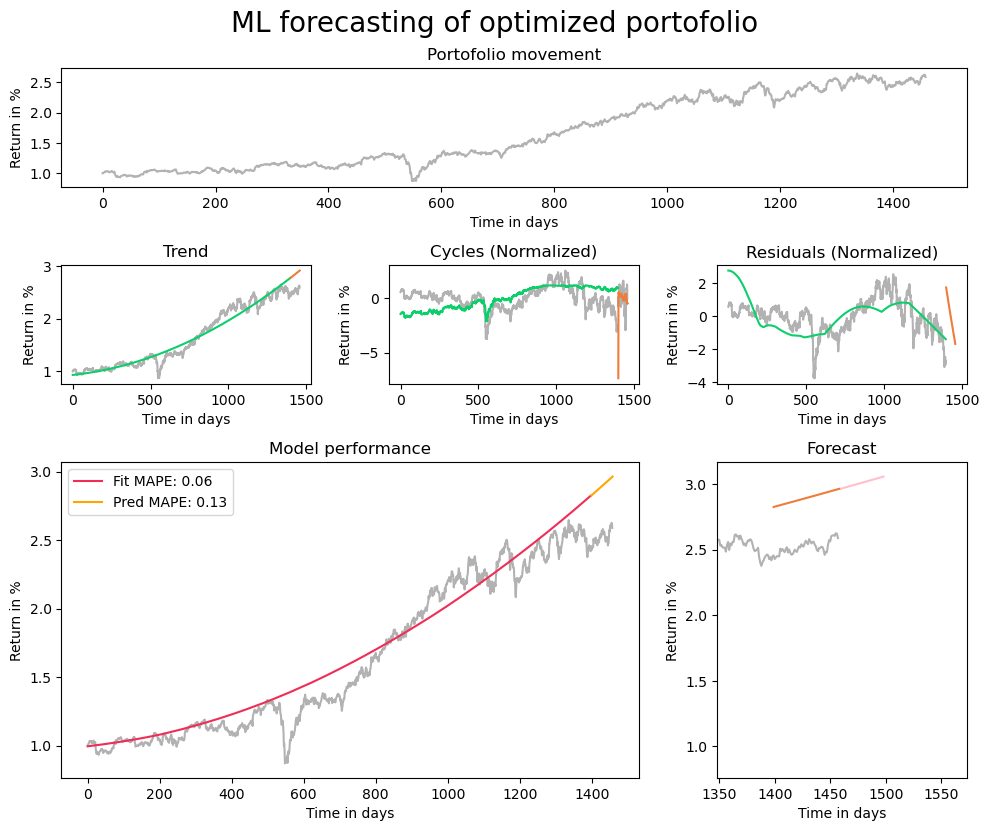

<Figure size 640x480 with 0 Axes>

In [565]:
pam = portofolio_actual_movement
fig = plt.figure(figsize=(10,10))

ax0 = plt.subplot2grid((5,3),(0,0), colspan=3, rowspan=1)
ax0.plot(pam, color='black', alpha=.3)

ax1 = plt.subplot2grid((5,3),(1,0)) 
ax1.plot(pam,color='black', alpha=.3)
ax1.plot(y_fit_trend, color='#0CCE6B')
ax1.plot(pred_idx, y_pred_trend, color='#ED7D3A')

ax2 = plt.subplot2grid((5,3),(1,1))
ax2.plot(normalize(y_train_cycle), color='black', alpha=.3)
ax2.plot(normalize(y_test_cycle), color='black', alpha=.3)
ax2.plot(normalize(y_fit_cyc_1), color='#0CCE6B')
ax2.plot(pred_idx, normalize(y_pred_cyc_1), color='#ED7D3A')


ax3 = plt.subplot2grid((5,3),(1,2)) 
ax3.plot(normalize(y_train_resid), color='black', alpha=.3)
ax3.plot(normalize(y_test_resid), color='black', alpha=.3)
ax3.plot(normalize(y_fit_resid_1), color='#0CCE6B')
ax3.plot(pred_idx, normalize(y_pred_resid_1), color='#ED7D3A')

ax4 = plt.subplot2grid((5,3),(2,0), colspan=2, rowspan=2)
ax4.plot(pam, color='black', alpha=.3)
ax4.plot(final_fit, color='#EF2D56', label='Fit MAPE: '+str(final_fit_mae))
ax4.plot(pred_idx, final_pred, color='orange', label='Pred MAPE: '+str(final_pred_mae))
plt.legend()


ax5 = plt.subplot2grid((5,3),(2,2), rowspan=2)
ax5.plot(pam, color='black', alpha=.3)
ax5.plot(for_idx, forecasts, color='pink')
ax5.plot(pred_idx, final_pred, color='#ED7D3A')
ax5.set_xlim(len(X_train)-50)

axes = [ax0,ax1,ax2,ax3,ax4,ax5]
axes_names = ['Portofolio movement','Trend','Cycles (Normalized)','Residuals (Normalized)', 'Model performance','Forecast']
for i in range(len(axes)):
    axes[i].set_title(axes_names[i])
    axes[i].set_xlabel('Time in days')
    axes[i].set_ylabel('Return in %')

# fig.sub_title('sd')
fig.suptitle('ML forecasting of optimized portofolio', fontsize=20)

fig.tight_layout()
plt.show()
plt.savefig('for_ex.png')

<h1> 9 Summary </h1>
<p> 
    To start I will mention that this programme is under development and has a lot of planned improvments.
</p>
<br>
<p> 
Now I comment my findings on the forecast plot. It seems like the model has a good ability to capture the trend of the portofolio, however it seems to have quite a potential of capturing both cycles and residuals better.
</p>
<ol> 
    <li> 
        The trend  prediction seems to capture the actual trend quite good
    </li>
    <li> 
        The model seems to capture the cycles quite well. However, the plot shows the normalized lines, and the weigths of this trend do not seem to be strong enough to have an impact on the actual timeseries predictons.
    </li>
    <li> 
        The model on residuals seems to encounter the same problem as the previous model. The model can detect the pattern, but its weight on the total predictions line is  way to small, and therfore its information is of little worth.
    </li>
</ol>
<p> 
    An inital thought about the time series model is that the model has potential of capturing both the cycles and residuals better. On possible way of fixing this problem is to performm some sort of feature engineering on the target variables for cycles and residuals. Maybe the model should be fitted after normalized values or maybe differenciated ones...
</p>
<em><h3> This programme is in a development phase </h3> </em>

